In [1]:
import pandas as pd
from pathlib import Path
import pylatex as pl
from pylatex.utils import NoEscape
import pymc as pm
import arviz as az
import nevergrad as ng
import plotly.express as px
import numpy as np
import pandas as pd

from estival.model import BayesianCompartmentalModel
import estival.priors as esp
import estival.targets as est
from estival.wrappers import pymc as epm
from tbdynamics import model
from tbdynamics.inputs import fixed_parameters
from tbdynamics.utils import build_contact_matrix
import plotly.graph_objects as go
from general_utils.parameter_utils import load_param_info
from general_utils.calibration_utils import round_sigfig
from general_utils.doc_utils import TextElement, TableElement, FigElement, add_element_to_document, \
    save_pyplot_add_to_doc, save_plotly_add_to_doc, compile_doc, generate_doc
from general_utils.tex_utils import StandardTexDoc


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pd.options.plotting.backend = "plotly"
time_start = 1800
time_end = 2020
time_step = 1

doc_sections = {}
compartments = [
    "susceptible",
    "early_latent",
    "late_latent",
    "infectious",
    "on_treatment",
    "recovered",
]
infectious_compartments = [
    "infectious",
    "on_treatment",
]

latent_compartments = [
    "early_latent",
    "late_latent",
]
age_strata = [0,5,15,35,50]

In [3]:
PROJECT_PATH = Path().resolve()
DATA_PATH = PROJECT_PATH / 'data'
SUPPLEMENT_PATH = PROJECT_PATH / 'supplement'

In [4]:
params = {
    "contact_rate": 0.009414102898074345,
    "start_population_size": 227344.75719536067,
    "cdr_adjustment": 0.6,
    "progression_multiplier": 1.1,
    "infectious_seed": 1,
    "rr_infection_latent": 0.2,
    "rr_infection_recovered": 0.2,
    "infect_death_rate_unstratified": 0.21,
    "on_treatment_infect_multiplier": 0.08,
    'smear_positive_death_rate':0.364337776897486,
    'smear_negative_death_rate': 0.027588310343242016, 
    'smear_positive_self_recovery': 0.20344728302826143,
    'smear_negative_self_recovery': 0.22723824998716693,
    'rr_progression_diabetes': 4.5
}

In [5]:
matrix = build_contact_matrix()

In [6]:
app_doc = StandardTexDoc(PROJECT_PATH / 'supplement', 'supplement', "TB dynamics Supplement", 'austcovid')

In [7]:
tb_model = model.build_model(
    compartments,
    infectious_compartments,
    latent_compartments,
    age_strata,
    time_start,
    time_end,
    time_step,
    matrix,
    fixed_parameters,
    app_doc
)

In [8]:
priors = [
    esp.UniformPrior("start_population_size", (1, 300000)),
    esp.UniformPrior("contact_rate", (0.0001, 0.02)),
    #UniformPrior("infectious_seed", [100, 2000]),
    esp.UniformPrior("rr_infection_latent", (0.2, 0.5)),
    esp.UniformPrior("rr_infection_recovered", (0.1, 0.5)),
    esp.UniformPrior("smear_positive_death_rate", (0.335, 0.449)),
    esp.UniformPrior("smear_negative_death_rate", (0.017, 0.035)),
    esp.UniformPrior("smear_positive_self_recovery", (0.177, 0.288)),
    esp.UniformPrior("smear_negative_self_recovery", (0.073, 0.209)),
    esp. UniformPrior("rr_progression_diabetes", (2.0, 10.0)),
    esp.UniformPrior("progression_multiplier", (0.1, 2.0)),
    # UniformPrior("cdr_adjustment", [0.6, 1.0]),
    # UniformPrior("infect_death_rate_dict.smear_positive", [0.335, 0.449]),
    # UniformPrior("infect_death_rate_dict.smear_negative", [0.017, 0.035]),
    # UniformPrior("self_recovery_rate_dict.smear_positive", [0.177, 0.288]),
    # UniformPrior("self_recovery_rate_dict.smear_negative", [0.073, 0.209]),
    # UniformPrior("rr_progression_diabetes", [1, 10]),
]
pop = pd.Series({2009: 1207100, 2019: 1194300})
notif = pd.Series({2011: 1495,2012: 1485,2013: 1369,2014:1405,2015:1642, 2016:1555, 2017:1440, 2018:1468, 2019:1417})
latent = pd.Series({2016:36})

targets = [
    est.NegativeBinomialTarget('total_population', pop, dispersion_param=2000),
    est.NegativeBinomialTarget('notifications', notif, dispersion_param=50),
    est.NegativeBinomialTarget('percentage_latent', latent, dispersion_param=5)
]
calibration_model = BayesianCompartmentalModel(tb_model, params, priors, targets)

In [9]:
with pm.Model() as pmc_model:
    start_params = {k: np.clip(v, *calibration_model.priors[k].bounds(0.99)) for k, v in params.items() if k in calibration_model.priors}
    variables = epm.use_model(calibration_model)
    map_params = pm.find_MAP(start=start_params, vars=variables, include_transformed=False)
    map_params = {k: float(v) for k, v in map_params.items()}
    print('Best calibration parameters found:')
for i_param, param in enumerate(map_params):
    print(f'   {param}: {round_sigfig(map_params[param], 4)} (within bound {priors[i_param].bounds()}')


Best calibration parameters found:
   start_population_size: 66730.0 (within bound (1.0, 300000.0)
   contact_rate: 0.01202 (within bound (0.0001, 0.02)
   rr_infection_latent: 0.2 (within bound (0.2, 0.5)
   rr_infection_recovered: 0.5 (within bound (0.1, 0.5)
   smear_positive_death_rate: 0.335 (within bound (0.335, 0.449)
   smear_negative_death_rate: 0.017 (within bound (0.017, 0.035)
   smear_positive_self_recovery: 0.2527 (within bound (0.177, 0.288)
   smear_negative_self_recovery: 0.1218 (within bound (0.073, 0.20900000000000002)
   rr_progression_diabetes: 10.0 (within bound (2.0, 10.0)
   progression_multiplier: 1.705 (within bound (0.1, 2.0)


In [10]:
params.update(map_params)
tb_model.run(params)

In [11]:
derived_df_0 = tb_model.get_derived_outputs_df()

In [12]:
plots = {"total_population": {
      "title": "Population size",
      "output_key": "total_population",
      "times": [2009.0, 2019.0],
      "values": [1207100, 1194300],
      "quantiles": [0.025, 0.25, 0.5, 0.75, 0.975]
    },
     "notifications": {
      "title": "Notifications",
      "output_key": "notifications",
      "times": [2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0],
      "values": [1495, 1485, 1369, 1405, 1642, 1555, 1440, 1468, 1417],
      "quantiles": [0.025, 0.25, 0.5, 0.75, 0.975]
    },
    "percentage_latent": {
      "title": "Percentage Latent",
      "output_key": "percentage_latent",
      "times": [2016.0],
      "values": [30.8],
      "quantiles": [0.025, 0.25, 0.5, 0.75, 0.975]
    },
    
    }

In [13]:
fig2_1 = px.line(
    derived_df_0,
    x=derived_df_0.index,
    y="total_population",
)
fig2_2 = px.scatter(x= plots['total_population']['times'], y = plots['total_population']['values'])
fig2_2.update_traces(marker=dict(color="red"))
fig2_3 = go.Figure(
    data=fig2_1.data + fig2_2.data,
)
fig2_3.update_layout(
    title="Modelled vs Data", title_x=0.5, xaxis_title="Year", yaxis_title="Population"
)
fig2_3.show()


In [14]:
notif_1 = px.line(
    derived_df_0,
    x=derived_df_0.index,
    y="notifications",
)
notif_2 = px.scatter(x= plots['notifications']['times'], y = plots['notifications']['values'])
notif_2.update_traces(marker=dict(color="red"))
notif_plot = go.Figure(
    data=notif_1.data + notif_2.data,
)
notif_plot.update_layout(
    title="Modelled vs Data", title_x=0.5, xaxis_title="Year", yaxis_title="Notifications"
)
notif_plot.show()
# notif_fig_name = "notifications.jpg"
# notif_plot.write_image(SUPPLEMENT_PATH / notif_fig_name)

In [15]:
prev_plot = px.line(
    derived_df_0,
    x=derived_df_0.index,
    y="prevalence_infectious",
)
prev_plot.show()
# prev_plot.write_image(str(SUPPLEMENT_PATH) + "/prevalance.jpg")

In [16]:
inci_plot = px.line(
    derived_df_0,
    x=derived_df_0.index,
    y="incidence",
)
inci_plot.show()
# inci_plot.write_image(str(SUPPLEMENT_PATH) + "/incidence.jpg")

In [17]:
latent_1 = px.line(
    derived_df_0,
    x=derived_df_0.index,
    y="percentage_latent",
)
latent_2 = px.scatter(x= plots['percentage_latent']['times'], y = plots['percentage_latent']['values'])
latent_2.update_traces(marker=dict(color="red"))
latent_plot = go.Figure(
    data=latent_1.data + latent_2.data,
)
latent_plot.update_layout(
    title="Modelled vs Data", title_x=0.5, xaxis_title="Year", yaxis_title="Percentage latent"
)
latent_plot.show()
# latent_plot.write_image(str(SUPPLEMENT_PATH) + "/latent.jpg")

In [18]:
import multiprocessing as mp
import platform

if platform.system() != "Windows":
    mp.set_start_method('forkserver')

In [19]:
# with pm.Model() as model:
    
#     # This is all you need - a single call to use_model
#     variables = epm.use_model(calibration_model)
    
#     # The log-posterior value can also be output, but may incur additional overhead
#     # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
#     # without transformation correction factors)
#     # pm.Deterministic("logp", model.logp(jacobian=False))
    
#     # Now call a sampler using the variables from use_model
#     # In this case we use the Differential Evolution Metropolis sampler
#     # See the PyMC docs for more details
#     idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=4000, tune=0,cores=4,chains=4)

c:\Users\vbui0010\Anaconda3\envs\tbdyn\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning:

Loop fusion failed because the resulting node would exceed the kernel argument limit.

Population sampling (4 chains)
DEMetropolis: [start_population_size, contact_rate, rr_infection_latent, rr_infection_recovered, smear_positive_death_rate, smear_negative_death_rate, smear_positive_self_recovery, smear_negative_self_recovery, rr_progression_diabetes, progression_multiplier]
c:\Users\vbui0010\Anaconda3\envs\tbdyn\lib\site-packages\pymc\sampling\population.py:84: UserWarning:

DEMetropolis should be used with more chains than dimensions! (The model has 10 dimensions.)

Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 0 tune and 4_000 draw iterations (0 + 16_000 draws total) took 263 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [20]:
import arviz as az

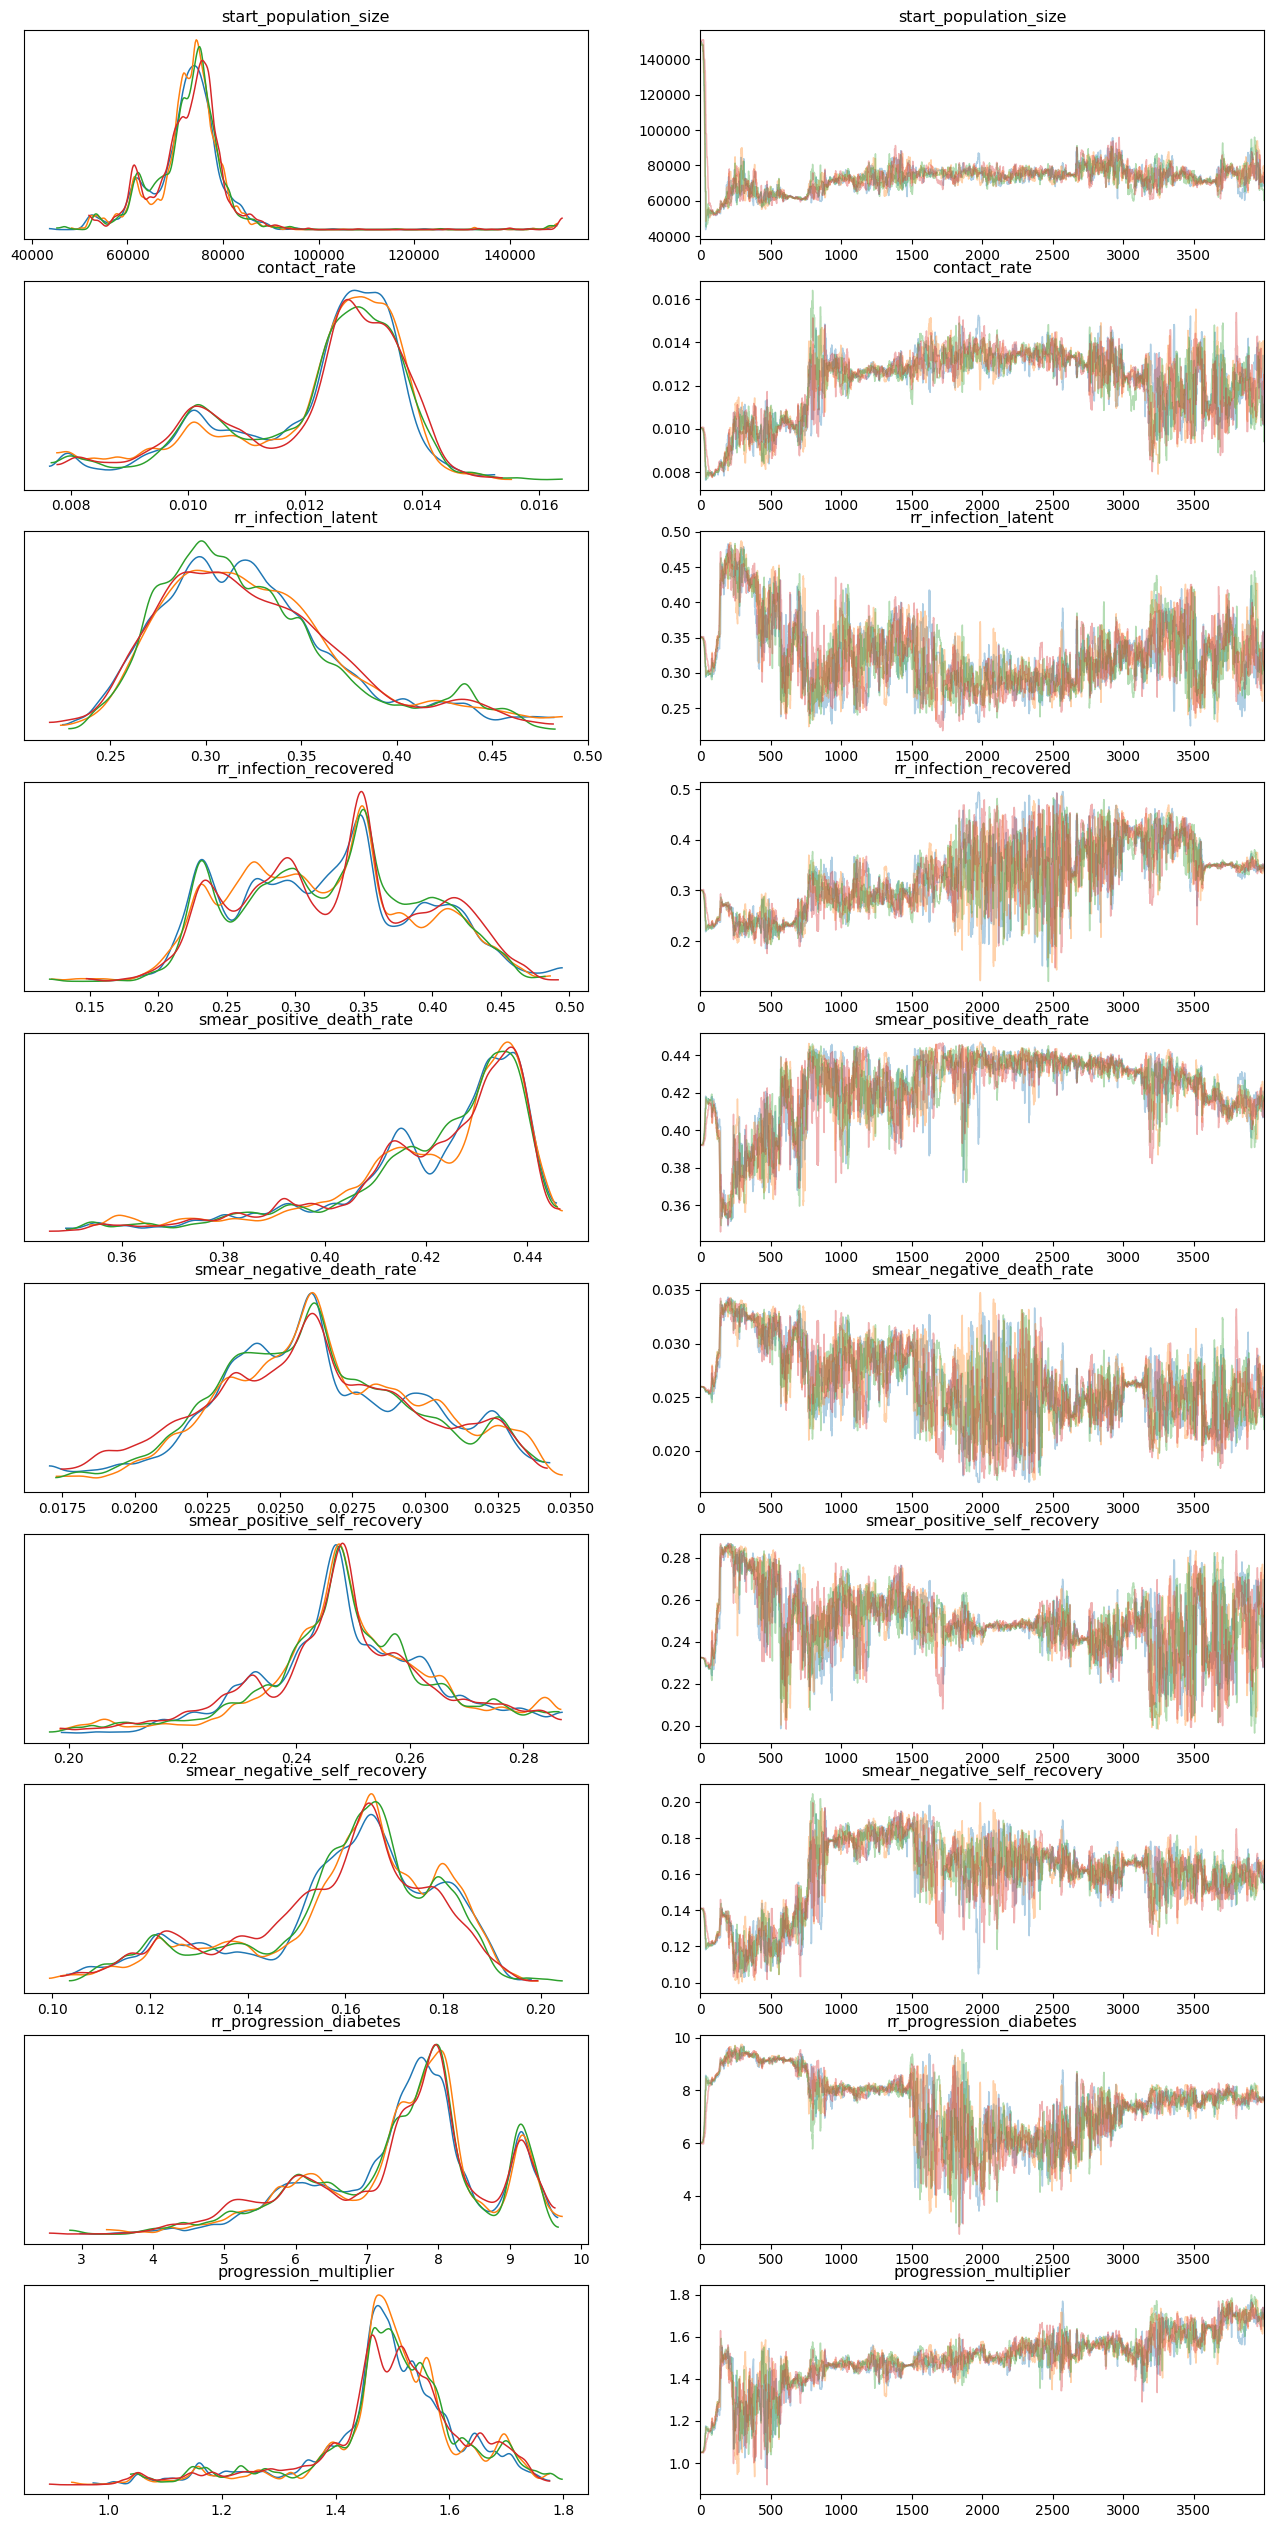

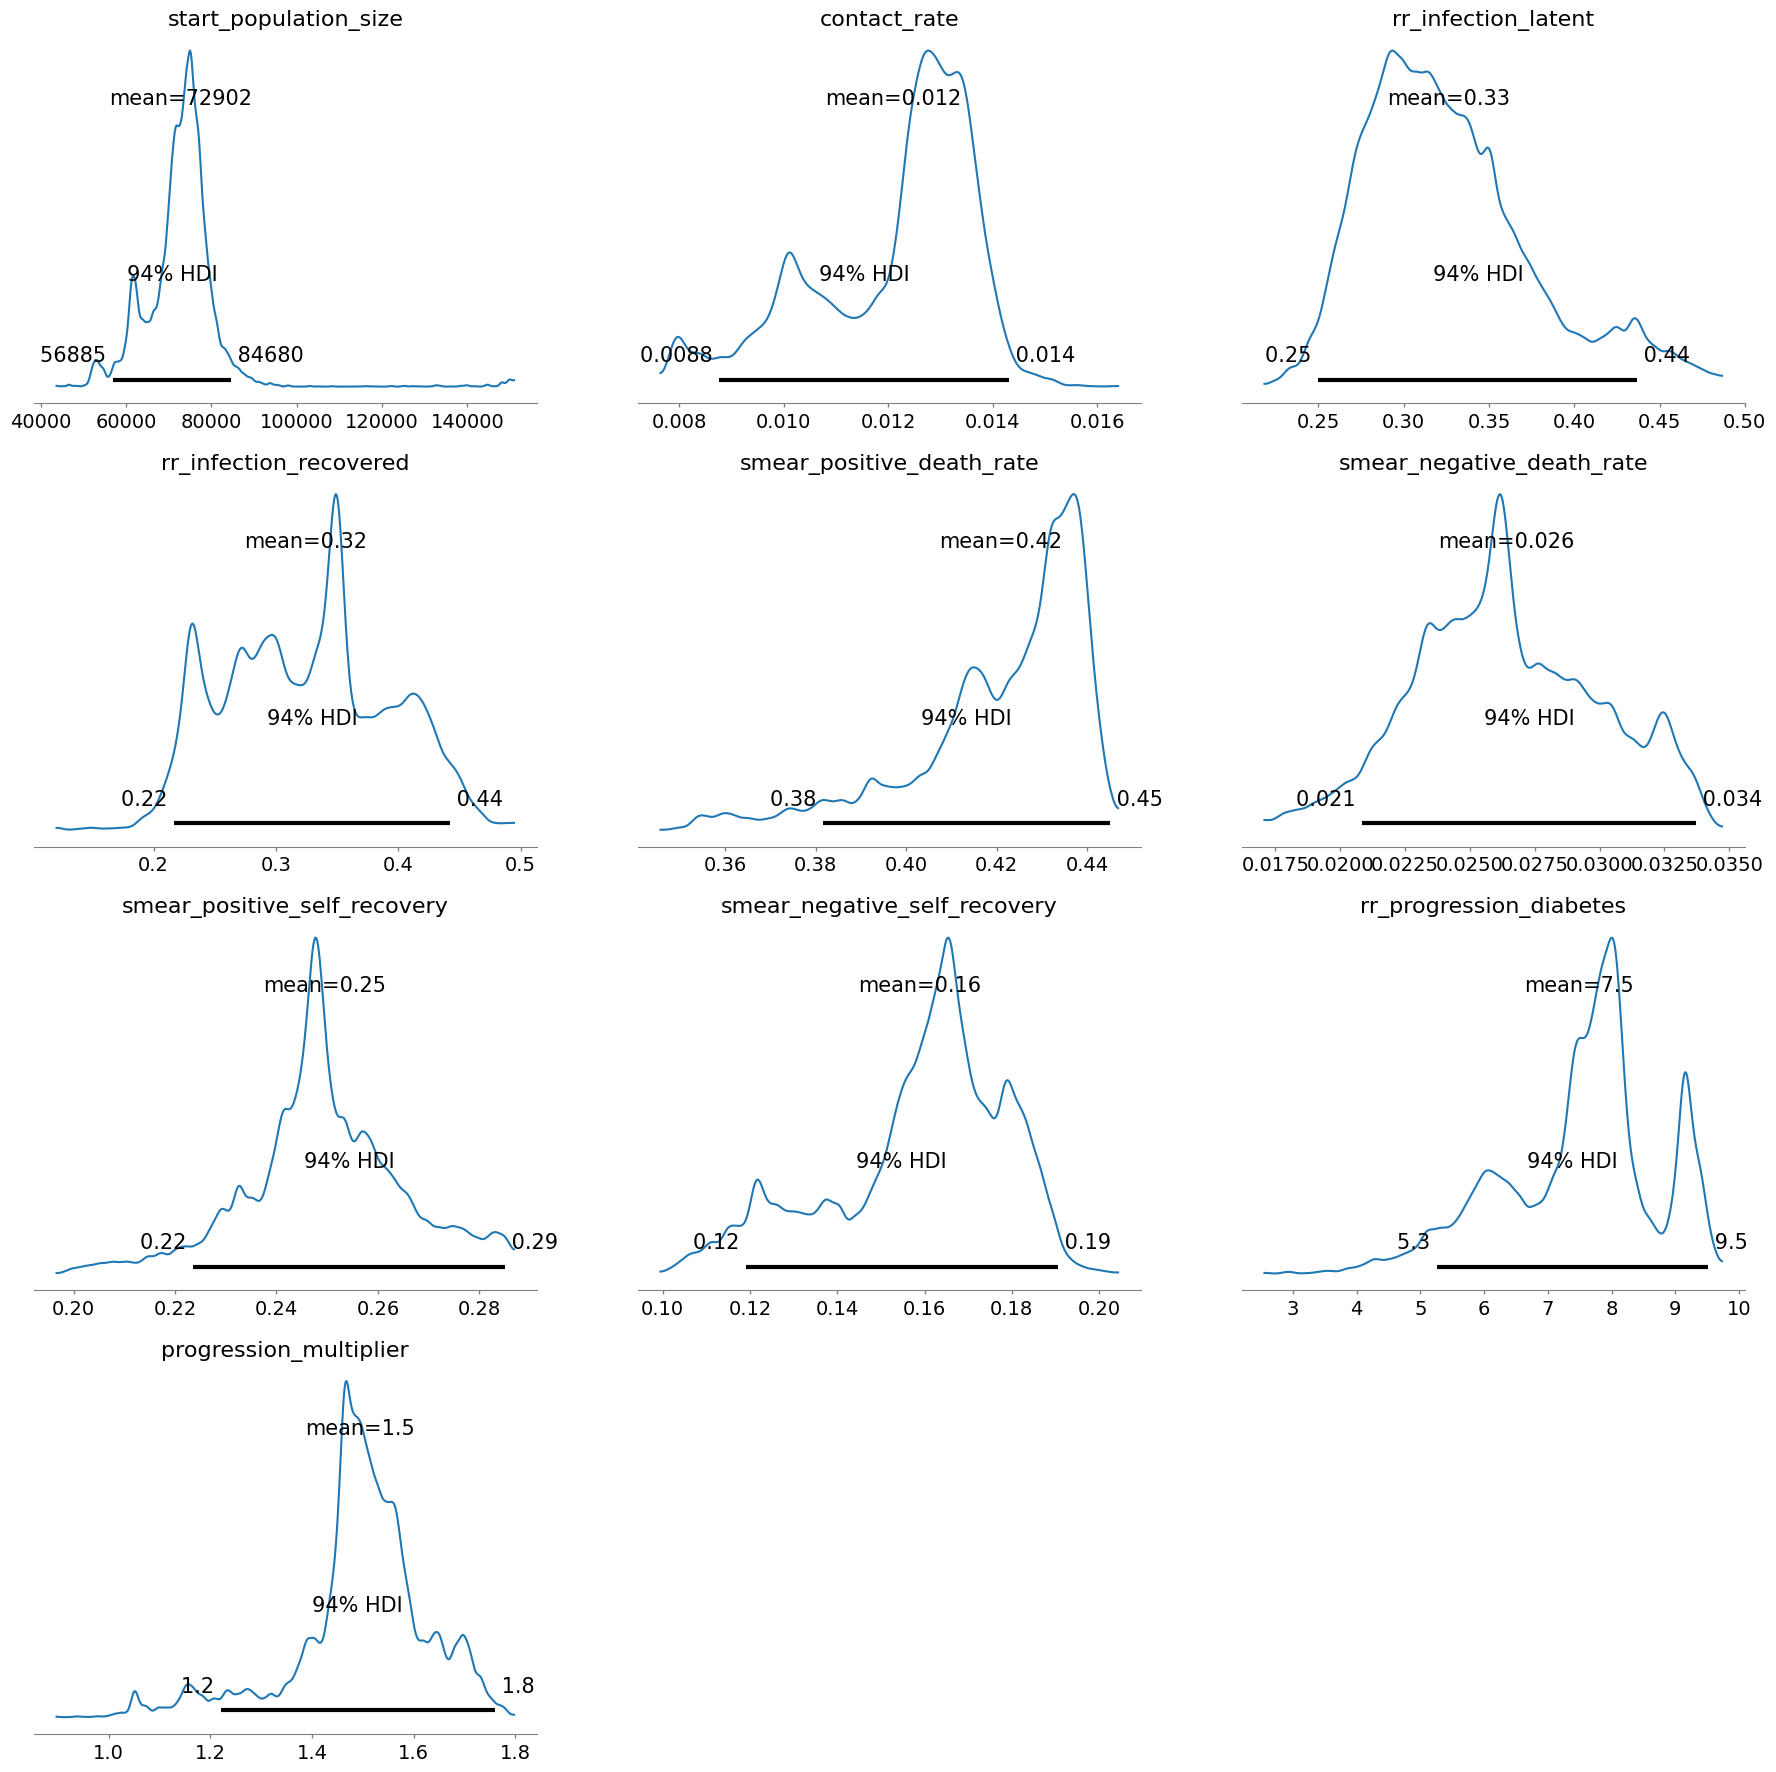

In [21]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
az.plot_posterior(idata);

In [22]:
section_order = [
    'Model Structure', 
    'Population', 
    'Stratification', 
]

In [23]:
app_doc.write_doc(order=section_order)